# 1. Executive Summary

## Problem

While browsing some good problem statements on Kaggle, I participated in the toxic comment classification challenge that was running at the time.
The background of the question comes from many online forums, and people participating in this actively participated and commented. Since comments can sometimes be abusive, insulting, or even hate-based speech, it is the responsibility of the hosting organization to ensure that these conversations are not negative. Therefore, the task is to build a model that can make predictions to classify reviews into various categories.

The goal of the competition was to detect toxicity (for example rudeness, disrespect, or threat) in user comments during online interaction. This is a very real-life problem given the increase in trolling and hatred on social media etc these days.

The problem was set up as a vanilla text classification problem where one had to predict the probability of a (text) comment being toxic and the submissions were evaluated on a ROC AUC metric.

The most interesting part of the problem was that — the toxicity had to be identified in 6 different languages, and there was no training data provided at all for 3 of them, and there was very little training data for the remaining 3.

The competition was organized by Jigsaw, which is a Google company, that builds tools to deal with problems like toxicity, disinformation, harassment radicalization in online content. This was the third toxicity detection competition conducted by Jigsaw (although the first one that was multilingual in nature).

## Data

The threat of abuse and harassment online prevent many people from expressing themselves and make them give up on seeking different opinions. In the meantime, platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments. Therefore, Kaggle started this competition with the Conversation AI team, a research initiative founded by Jigsaw and Google. The competition could be found here: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

As a group of students with great interests in Natural Language Processing, as well as making online discussion more productive and respectful, we determined to work on this project and aim to build a model that is capable of detecting different types of toxicity like threats, obsenity, insults, and identity-based hate. 

The dataset we are using consists of comments from Wikipedia’s talk page edits. These comments have been labeled by human raters for toxic behavior. The types of toxicity are:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

There are 159,571 observations in the training dataset and 153,164 observations in the testing dataset. Since the data was originally used for a Kaggle competition, in the test_labels dataset there are observations with labels of value -1 indicating it was not used for scoring.

## Findings - Multilabel vs Multiclass classification?

As the task was to figure out whether the data belongs to zero, one, or more than one categories out of the six listed above, the first step before working on the problem was to distinguish between multi-label and multi-class classification.
In multi-class classification, we have one basic assumption that our data can belong to only one label out of all the labels we have. For example, a given picture of a fruit may be an apple, orange or guava only and not a combination of these.
In multi-label classification, data can belong to more than one label simultaneously. For example, in our case a comment may be toxic, obscene and insulting at the same time. It may also happen that the comment is non-toxic and hence does not belong to any of the six labels.
Hence, I had a multi-label classification problem to solve. The next step was to gain some useful insights from data which would aid further problem solving.

# 2. Benchmarking and Other Solutions

## a. NB-SVM strong linear baseline(Succeeded, Score: 0.98117)


### Feature Approach

This kernel shows how to use NBSVM (Naive Bayes - Support Vector Machine) to create a strong baseline for the Toxic Comment Classification Challenge competition. NBSVM was introduced by Sida Wang and Chris Manning in the paper Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation. In this kernel, we use sklearn's logistic regression, rather than SVM, although in practice the two are nearly identical (sklearn uses the liblinear library behind the scenes).

### Model Approach

Variants of Naive Bayes (NB) and Support Vector Machines (SVM) are often used as baseline methods for text classification, but their performance varies greatly depending on the model variant, features used and task/dataset. We show that: (i) the inclusion of word bigram features gives consistent gains on sentiment analysis tasks; (ii) for short snippet sentiment tasks, NB actually does better than SVMs (while for longer documents the opposite result holds); (iii) a simple but novel SVM variant using NB log-count ratios as feature values consistently performs well across tasks and datasets. Based on these observations, we identify simple NB and SVM variants which outperform most published results on sentiment analysis datasets, sometimes providing a new state-of-the-art performance level.

### Comments

NBSVM performs well on snippets and longer documents, for sentiment, topic and subjectivity classification, and is often better than previously published results. Therefore, NBSVM seems to be an appropriate and very strong baseline for sophisticated methods aiming to beat a bag of features.

## b. Improved LSTM baseline: GloVe + dropout(Succeeded, Score: 0.97718)

### Feature Approach

CountVectorizer

Creates a matrix with frequency counts of each word in the text corpus

### Model Approach

LSTM


### Comments

The sigmoid activation serves the purpose of predicting a yes or a no for each of the 6 classes because it is possible to have an input be labelled with several classes at once (whereas the softmax likes to predict the class with highest likelihood) . Therefore the binary_crossentropy loss is appropriate for finding the difference between each class prediction

## c. Logistic regression with words and char n-grams(Succeeded, Score: 0.97565)

### Feature Approach

As tf–idf is very often used for text features, there is also another class called TfidfVectorizer that combines all the options of CountVectorizer and TfidfTransformer in a single model.

TfidfVectorizer is a CountVectorizer followed by TfidfTransformer.

### Model Approach

Logistic Regression

### Comments

The difference between using "all_text" and "train_text" is there will be some extra features which only exist in the test set. In other words, the training set contains no information regarding those extra features. So I think using "all_text" and "train_text" to fit would give theoretically the same result when we do classification on the test set.

# 3. Data Description and Initial Processing

In [3]:
# from google.colab import files
# uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Number of rows and columns in the train data set:',train.shape)
print('Number of rows and columns in the test data set:',test.shape)

Number of rows and columns in the train data set: (159571, 8)
Number of rows and columns in the test data set: (153164, 2)


In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Below is a plot showing the comment length frequency. As noticed, most of the comments are short with only a few comments longer than 1000 words.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


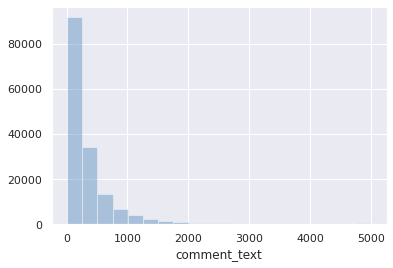

In [8]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="steelblue")

Further exploratory shows that label toxic has the most observations in the training dataset while threat has the least.

In [9]:
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

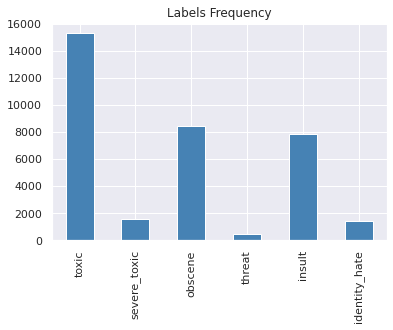

In [10]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

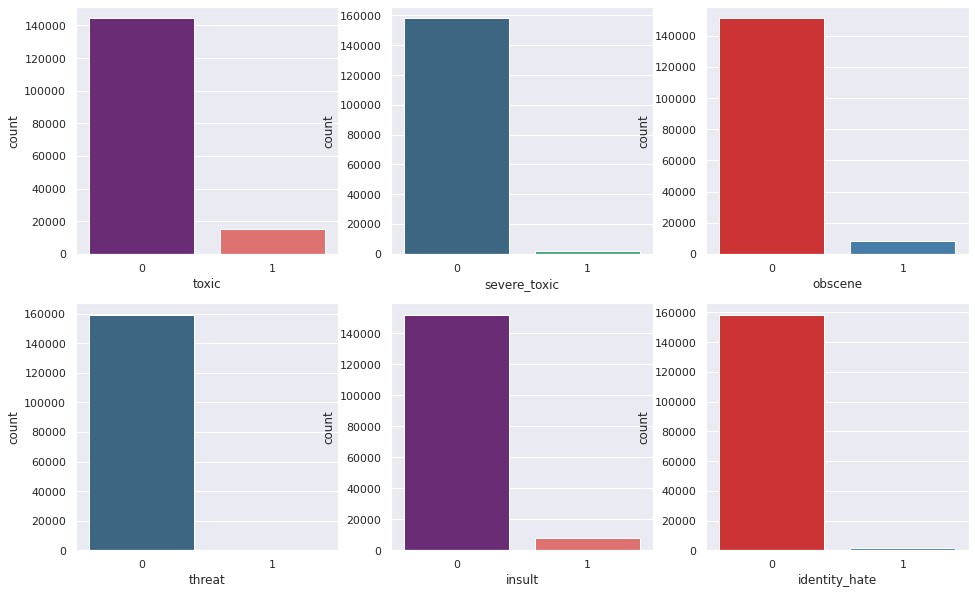

In [13]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6)

In [14]:
k = pd.DataFrame()
k['train'] = train.isnull().sum()
k['test'] = test.isnull().sum()
k

,train,test
id,0,0.0
comment_text,0,0.0
toxic,0,NaN
severe_toxic,0,NaN
obscene,0,NaN
threat,0,NaN
insult,0,NaN
identity_hate,0,NaN


In [17]:
test.fillna(' ',inplace=True)
gc.collect()

500

Below is the plot for the labeled data frequency. There is significant class imbalance since majority of the comments are considered non-toxic.

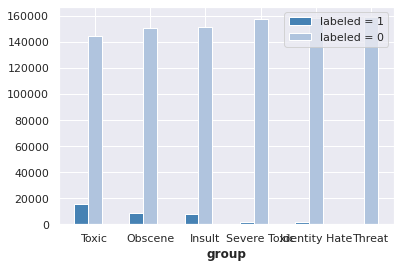

In [19]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.25

bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['severe_toxic'] == 1),
         sum(train['identity_hate'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['severe_toxic'] == 0),
         sum(train['identity_hate'] == 0), sum(train['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate',
                                                       'Threat'])
plt.legend()
plt.show()


In [20]:
# example of clean comment
train.comment_text[0]

# example of toxic comment
train[train.toxic == 1].iloc[1, 1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'